In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

In [2]:
path = "../features/normalized/"
names = ["betweenness", "community_count", "community_size", "ks_level_1", "ks_level_2"]
used_names = ["community_size","ks_level_1", "ks_level_2"]
np.random.seed(42)
samples_per_class = 35
model = LogisticRegression(random_state=42)

In [3]:
# Load features from .npz files
original_labels = np.load(path + names[0] + "_norm.npz")['y']
original_features = np.load(path + names[0] + "_norm.npz")['X']
columns = [original_features.shape[1]]
for filename in names[1:]:
    file_path = path + filename + "_norm.npz"
    data = np.load(file_path)
    feature_matrix = data['X']
    columns.append(feature_matrix.shape[1])
    original_features = np.concatenate((original_features, feature_matrix), axis=1)

# Over-sample
original_samples_per_class = {label: np.sum(original_labels == label) for label in np.unique(original_labels)}
sampling_strategy = {label: max(samples_per_class, original_samples) for label, original_samples in original_samples_per_class.items()}
ros = RandomOverSampler(random_state=42, sampling_strategy=sampling_strategy)
oversampled_features, oversampled_labels = ros.fit_resample(original_features, original_labels)
# Under-sample
updated_samples_per_class = {label: np.sum(oversampled_labels == label) for label in np.unique(original_labels)}
sampling_strategy = {label: min(samples_per_class, original_samples) for label, original_samples in updated_samples_per_class.items()}
rus = RandomUnderSampler(random_state=42, sampling_strategy=sampling_strategy)
undersampled_features, labels = rus.fit_resample(oversampled_features, oversampled_labels)

# Build features list
all_features = []
current = 0
for c in columns:
    feature = undersampled_features[:, current:current + c]
    all_features.append(feature)
    current += c

In [4]:
# Filter indices
ks1 = all_features[names.index("ks_level_1")]
ks2 = all_features[names.index("ks_level_2")]
features = [all_features[names.index(f)] for f in used_names]

# Filter l1
l1_thr = np.percentile(np.mean(ks1, axis=0), 50)

# Filter l2 based on l1
l1_filtered_coefficients_low = np.where(np.mean(ks1, axis=0) < l1_thr)[0]
l1_filtered_coefficients_high = np.where(np.mean(ks1, axis=0) > l1_thr)[0]

l2_thr_low = np.percentile(np.mean(ks2[:, l1_filtered_coefficients_low], axis=0), 50) 
l2_thr_high = np.percentile(np.mean(ks2[:, l1_filtered_coefficients_high], axis=0), 50)  

In [5]:
def evaluate(X):
    # Perform logistic regression and compute accuracy
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42, stratify=labels)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [6]:
# Define a function to filter and evaluate data for each class
def filter_and_evaluate(condition):
    filtered_coefficients = np.where(condition)[0]
    if filtered_coefficients.size > 0:
        X = np.hstack([f[:, filtered_coefficients] if f.shape[1] >= filtered_coefficients.max() + 1 else f for f in features])
        accuracy = evaluate(X)
        data_percentage = (filtered_coefficients.shape[0] / all_features[names.index("ks_level_1")].shape[1])
        return accuracy, data_percentage
    else:
        return 0, 0

In [7]:
# Class 1: ks1 < L1_threshold and ks2 < L2_threshold
accuracy, data_percentage = filter_and_evaluate((np.mean(ks1, axis=0) < l1_thr) & (np.mean(ks2, axis=0) < l2_thr_low))
print(f"Class Low-Low: accuracy = {accuracy*100:4.2f}%; retained features = {data_percentage*100:4.2f}%")

# Class 2: ks1 < L1_threshold and ks2 >= L2_threshold
accuracy, data_percentage = filter_and_evaluate((np.mean(ks1, axis=0) < l1_thr) & (np.mean(ks2, axis=0) >= l2_thr_low))
print(f"Class Low-High: accuracy = {accuracy*100:4.2f}%; retained features = {data_percentage*100:4.2f}%")

# Class 3: ks1 >= L1_threshold and ks2 < L2_threshold
accuracy, data_percentage = filter_and_evaluate((np.mean(ks1, axis=0) >= l1_thr) & (np.mean(ks2, axis=0) < l2_thr_high))
print(f"Class High-Low: accuracy = {accuracy*100:4.2f}%; retained features = {data_percentage*100:4.2f}%")

# Class 4: ks1 >= L1_threshold and ks2 >= L2_threshold
accuracy, data_percentage = filter_and_evaluate((np.mean(ks1, axis=0) >= l1_thr) & (np.mean(ks2, axis=0) >= l2_thr_high))
print(f"Class High-High: accuracy = {accuracy*100:4.2f}%; retained features = {data_percentage*100:4.2f}%")


Class Low-Low: accuracy = 6.55%; retained features = 24.92%
Class Low-High: accuracy = 12.36%; retained features = 24.92%
Class High-Low: accuracy = 25.42%; retained features = 25.23%
Class High-High: accuracy = 56.82%; retained features = 24.92%


In [8]:
percentiles1 = [40, 30, 25, 25, 20, 20, 15, 15, 10, 10, 5, 5]
percentiles2 = [40, 30, 30, 25, 25, 20, 20, 15, 15, 10, 10, 5]
accuracies = []
data_percentages = []

for p1, p2 in zip(percentiles1, percentiles2):
    l1_thr = np.percentile(np.mean(ks1, axis=0), p1)
    l1_filtered_coefficients = np.where(np.mean(ks1, axis=0) > l1_thr)[0]
    l2_thr = np.percentile(np.mean(ks2[:, l1_filtered_coefficients], axis=0), p2) 
    accuracy, data_percentage = filter_and_evaluate((np.mean(ks1, axis=0) >= l1_thr) & (np.mean(ks2, axis=0) >= l2_thr))
    accuracies.append(accuracy)
    data_percentages.append(data_percentage)
    print(f"Percentiles --> {100-p1}% of L1 and {100-p2}% of L2; Accuracy = {accuracy*100:4.2f}%; Retained features = {data_percentage*100:4.2f}%")

Percentiles --> 60% of L1 and 60% of L2; Accuracy = 72.75%; Retained features = 36.00%
Percentiles --> 70% of L1 and 70% of L2; Accuracy = 80.98%; Retained features = 48.92%
Percentiles --> 75% of L1 and 70% of L2; Accuracy = 82.72%; Retained features = 52.31%
Percentiles --> 75% of L1 and 75% of L2; Accuracy = 84.22%; Retained features = 56.00%
Percentiles --> 80% of L1 and 75% of L2; Accuracy = 85.28%; Retained features = 60.00%
Percentiles --> 80% of L1 and 80% of L2; Accuracy = 86.00%; Retained features = 64.00%
Percentiles --> 85% of L1 and 80% of L2; Accuracy = 86.76%; Retained features = 67.69%
Percentiles --> 85% of L1 and 85% of L2; Accuracy = 87.68%; Retained features = 71.69%
Percentiles --> 90% of L1 and 85% of L2; Accuracy = 88.14%; Retained features = 76.00%
Percentiles --> 90% of L1 and 90% of L2; Accuracy = 88.73%; Retained features = 80.92%
Percentiles --> 95% of L1 and 90% of L2; Accuracy = 88.81%; Retained features = 84.00%
Percentiles --> 95% of L1 and 95% of L2; Ac

In [9]:
# Compute the max accuracy
X = np.hstack([f for f in features])
max_accuracy = evaluate(X)
print(f"Max accuracy = {accuracy*100:4.2f}% (retaining all features)")
# Append data
accuracies.append(max_accuracy)
data_percentages.append(1)

Max accuracy = 88.88% (retaining all features)


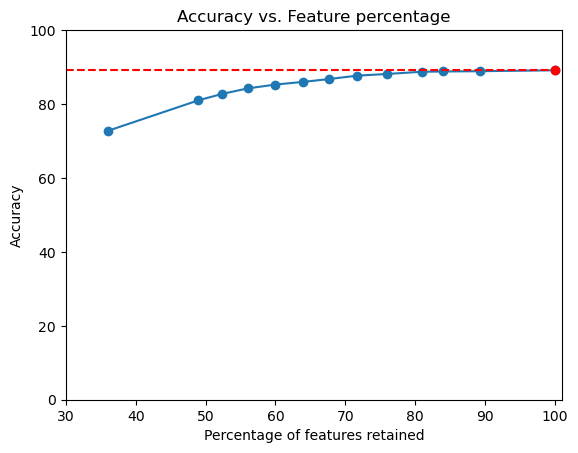

In [17]:
# Plot accuracies for each model
plt.plot(np.array(data_percentages)*100, np.array(accuracies)*100, marker='o')
plt.axhline(y=np.max(accuracies)*100, color='r', linestyle='--', label='')
plt.plot(100, np.max(accuracies)*100, color='r', marker='o')
plt.xlabel('Percentage of features retained')
plt.ylabel('Accuracy')
plt.ylim(0, 100)
plt.xlim(30, 101)
plt.title('Accuracy vs. Feature percentage')
plt.show()

## Comparison with the original (WIP)

In [ ]:
import time
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score

# Sample models (replace with your actual models)
model1, model2 = Model1(), Model2()

# Training data (X and labels)
X_train, y_train = ...

# Record training time and train the first model
start_time = time.time()
model1.fit(X_train, y_train)
training_time_model1 = time.time() - start_time

# Do the same for the second model
start_time = time.time()
model2.fit(X_train, y_train)
training_time_model2 = time.time() - start_time


In [ ]:
X_test, y_test = ...  # Test data

# Predictions for each model
predictions1 = model1.predict(X_test)
predictions2 = model2.predict(X_test)

# Calculate metrics for Model 1
precision1 = precision_score(y_test, predictions1)
recall1 = recall_score(y_test, predictions1)
accuracy1 = accuracy_score(y_test, predictions1)
auc1 = roc_auc_score(y_test, predictions1)

# Calculate metrics for Model 2
precision2 = precision_score(y_test, predictions2)
recall2 = recall_score(y_test, predictions2)
accuracy2 = accuracy_score(y_test, predictions2)
auc2 = roc_auc_score(y_test, predictions2)


In [ ]:
import matplotlib.pyplot as plt

metrics1 = [precision1, recall1, auc1, accuracy1]
metrics2 = [precision2, recall2, auc2, accuracy2]
labels = ['Precision', 'Recall', 'AUC', 'Accuracy']

plt.figure(figsize=(10, 6))

# Create subplots for each metric
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.bar(['Model 1', 'Model 2'], [metrics1[i], metrics2[i]])
    plt.title(labels[i])
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()


In [ ]:
# Assuming model1 and model2 have a way to report the number of features used
n_features_model1 = ...
n_features_model2 = ...

# Plotting the complexity metrics
plt.figure(figsize=(10, 4))

# Number of features
plt.subplot(1, 2, 1)
plt.bar(['Model 1', 'Model 2'], [n_features_model1, n_features_model2])
plt.title('Number of Features')

# Training time
plt.subplot(1, 2, 2)
plt.bar(['Model 1', 'Model 2'], [training_time_model1, training_time_model2])
plt.title('Training Time')

plt.tight_layout()
plt.show()
